## Load packages and set up notebook

This notebook was run on a GPU-enabeled Google Collab notebook.

NVIDIA V100 with 16GB of GPU RAM

In [1]:
!nvidia-smi

Thu Dec 21 22:54:22 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install scikit-multilearn
!pip install pycalib
!pip install torcheval

from google.colab import drive
drive.mount('/content/drive')

!unzip -q /content/drive/MyDrive/FF/data.zip -d .

!mkdir predictions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycalib: filename=pycalib-0.1.0.dev6-py3-none-any.whl size=37282 sha256=4662fe3377d4a65fd0d03ab43af5eea0ba073a60ff5ec63445d77f938717ea5e
  Stored in directory: /root/.cache/pip/wheels/8c/4a/b3/ac02811022820c141bf30688d9b6af4dafcdbb30f7d77efc2c
Successfully built pycalib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.1 MB/s eta 0:00:00
Mounted at /content/drive


In [55]:
# packages
import os
from pathlib import Path
import pickle
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from transformers import AutoModelForImageClassification

from pycalib.visualisations import plot_reliability_diagram
from pycalib.metrics import conf_ECE, classwise_ECE

# constants
BASE_DIR = Path('./')
DATA_DIR = BASE_DIR / 'data'
TRAIN_DIR, TEST_DIR = DATA_DIR / 'train', DATA_DIR / 'test'
TRAIN_CSV, TEST_CSV = DATA_DIR / 'train.csv', DATA_DIR / 'submission.csv'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = 10

# mean and std of image channels in the dataset
MEAN = torch.tensor([0.05409202, 0.05213123, 0.07833622])
STD = torch.tensor([0.39014456, 0.31953841, 0.36855768])

label_map = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles',
}

# hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 20
WEIGHT_DECAY = 0.001
THRESHOLD = 0.5
N_SPLITS = 10
CI_WEIGHTER = 0.2
PATIENCE = 1

# transforms
TRANSFORM_TRAIN = v2.Compose([
    v2.ToImage(),
    v2.Resize((64, 64), antialias=True),
    v2.RandomHorizontalFlip(0.1),
    v2.RandomVerticalFlip(0.1),
    v2.RandomRotation(0),
    v2.RandomResizedCrop(64, scale=(0.95, 1.0), ratio=(1.0, 1.0), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=MEAN, std=STD),
])
TRANSFORM_TEST = v2.Compose([
    v2.ToImage(),
    v2.Resize((300, 300), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=MEAN, std=STD),
])

# progressive learning parameters
# sizes = np.round(np.linspace(64, 300, NUM_EPOCHS)).astype(int).tolist() # better to keep size equal in last few epoch
# sizes = [64, 96, 128, 128, 160, 160, 192, 192, 192, 224, 224, 224, 256, 256, 256, 256, 288, 288, 288, 288, 300, 300, 300, 300, 300] # 25 epoch case
sizes = [64, 64, 96, 96, 128, 128, 160, 160, 192, 192, 224, 224, 256, 256, 288, 288, 300, 300, 300, 300] # 20 epoch case
flip_probs = np.linspace(0, 0.5, NUM_EPOCHS).astype(np.float32).tolist()
rotations = np.linspace(0, 180, NUM_EPOCHS).astype(np.float32).tolist()
scales = np.linspace(1.0, 0.5, NUM_EPOCHS).astype(np.float32).tolist()
dropouts = np.linspace(0.0, 0.5, NUM_EPOCHS).astype(np.float32).tolist()

sns.set_theme()
print('Using {} device'.format(DEVICE))

Using cuda device


The image transformations shown here played a very important role in final model performance.

Most notably:
- `Normalization` : Makes features more numerically stable
- `Resize` : The best models were pre-trained ImageNet models that had parameters adjusted to the 224×224 or 300x300 image size.

> Resizing the images in this fashion is computationally quite unfortunate but was worth it because of the notable increase in performance (>60% F1).

I also made use of "progressive learning" as described by [Mingxing Tan and Quoc V. Le (2021)](https://doi.org/10.48550/arXiv.2104.00298). Main idea: throughout training process, progressively increase image size and degree of regularization (through e.g. transformations and dropout). This speeds up the training process and improves overall performance.

## Basic helper functions

In [56]:
def encode_label(label):
    """
    Converts a label string into a one-hot encoded tensor
    """
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    """
    Converts a one-hot encoded tensor into a label string
    """
    result = []
    for i, x in enumerate(target):
        if (float(x) >= threshold):
            if text_labels:
                result.append(label_map[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

def show_sample(path, target, invert=True, threshold=0.5):
    """
    Displays a sample image and its labels
    """
    image = Image.open(path)
    if invert:
        plt.imshow(1 - np.asarray(image))
    else:
        plt.imshow(image)
    plt.title(decode_target(target, threshold=threshold, text_labels=True))
    return plt

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(RANDOM_SEED)

## Explore the data

During data exploration, it was noted which labels were most under-represented. Since the evaluation metric for the competition is a macro-averaged F1-score, performance on these under-represented labels was optimzed through various strategies.

It could perhaps also be noted here that some images have very sparse data (sometimes the images are just black squares).

Number of labeled images: 15389 



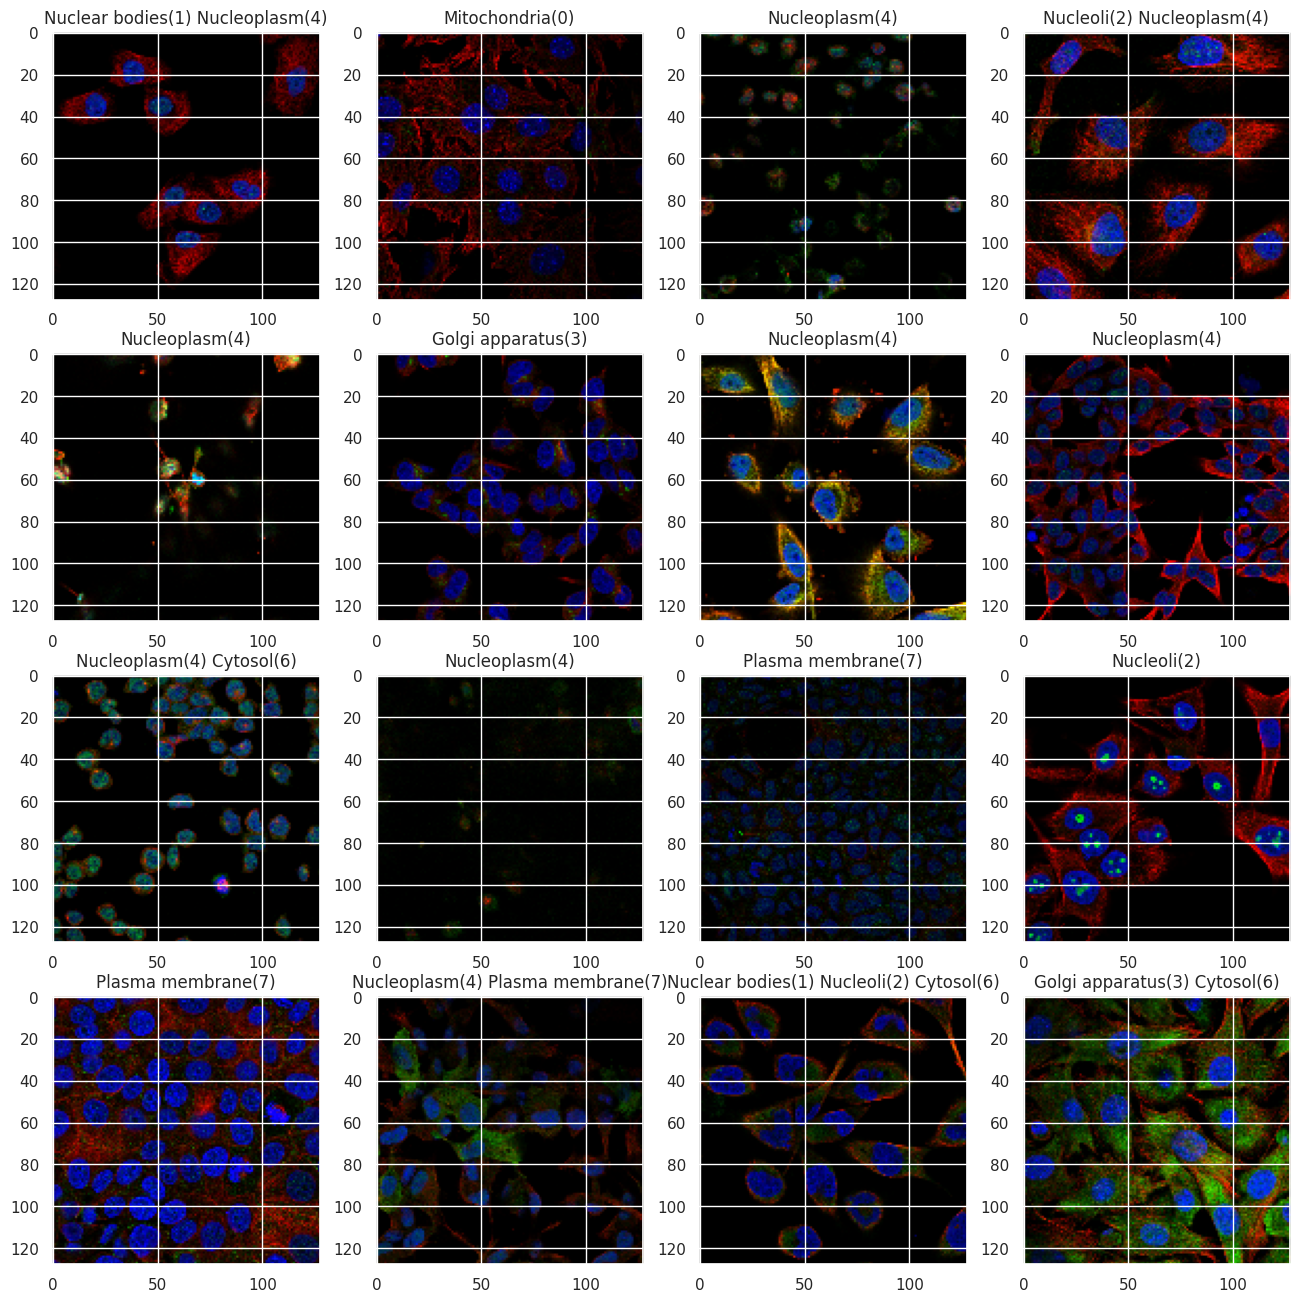

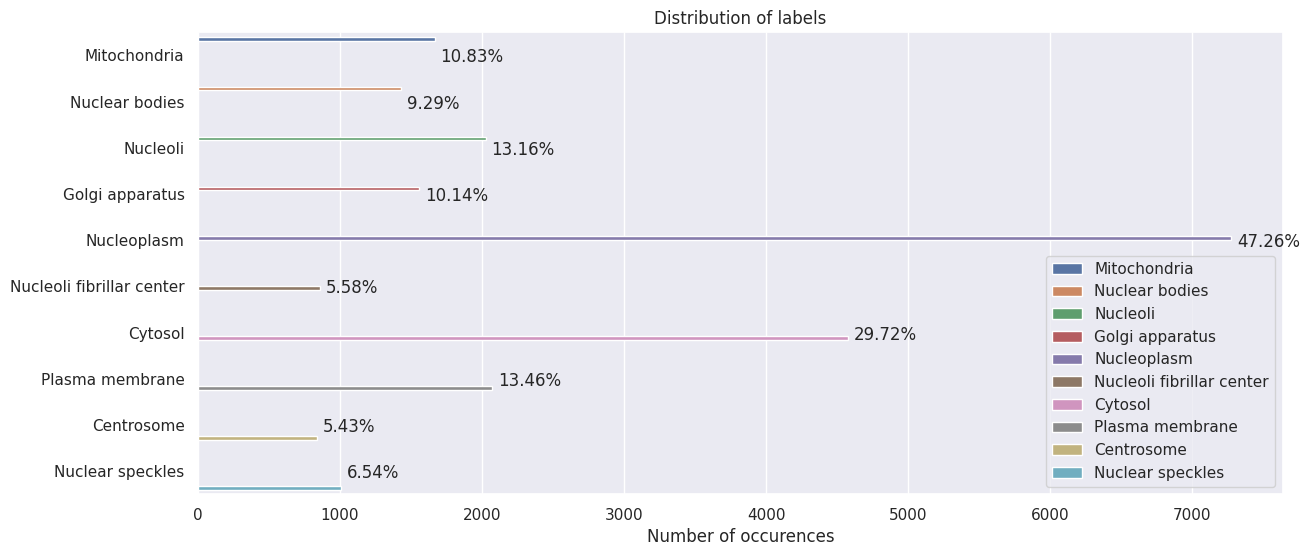

In [57]:
df = pd.read_csv(TRAIN_CSV)
print("Number of labeled images:", len(df), '\n')

# visualize some samples
fig = plt.figure(figsize=(16, 16))
for i in range(16):
    # sample value from df['Image']
    img_path = TRAIN_DIR / (str(df.iloc[i, 0]) + '.png')
    label = df.iloc[i, 1]
    target = encode_label(label)
    plt.subplot(4, 4, i + 1)
    show_sample(img_path, target, invert=False)
plt.show()


# visualize class-imbalance
def show_class_imbalance():
    mlb = MultiLabelBinarizer()
    counts = pd.DataFrame(
        mlb.fit_transform(df['Label'].apply(lambda x: x.split(' '))),
        columns=mlb.classes_, index=df.index).sum()

    fig, ax = plt.subplots(figsize=(14, 6))
    sns.barplot(
        # use label_map as x
        x=counts.values,
        y=[label_map[i] for i in range(10)],
        orient='h',
        hue=[label_map[i] for i in range(10)],
        ax=ax)
    ax.set_title("Distribution of labels")
    ax.set(xlabel="Number of occurences")
    for i, v in enumerate(counts.values):
        ax.text(v + 40, i + .15, str(np.round(100 * v / len(df), 2)) + '%')
    return fig

class_imbalance_plot = show_class_imbalance()

In [59]:
mlb = MultiLabelBinarizer()
counts = pd.DataFrame(
    mlb.fit_transform(df['Label'].apply(lambda x: x.split(' '))),
    columns=mlb.classes_, index=df.index).sum()

WEIGHT = torch.tensor(len(df) / counts)
WEIGHTS = [(WEIGHT * w) + (torch.ones(10) * (1 - w)) for w in np.linspace(0, CI_WEIGHTER, NUM_EPOCHS)]

A weight parameter was added to the training-loss function to account for the class imbalance.

As epochs progress, relatively more weight is given to the under-represented classes. This makes training more difficult at later epochs and it expresses itself in a somewhat upward trending train-loss curves. The value for `CI_WEIGHTER` determines to what extent over-represented labels are deprioritized and this was set somewhat arbitrary.

In the last epoch, the weight for the least common label is 3.66x larger that the weight of the most common label. Higher values for `CI_WEIGHTER` are possible and may have a beneficial effect on validation-loss but I tried to make sure the upward training-loss trend was not too severe.

In [60]:
WEIGHTS

[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64),
 tensor([1.0867, 1.1028, 1.0695, 1.0933, 1.0117, 1.1781, 1.0249, 1.0677, 1.1832,
         1.1503], dtype=torch.float64),
 tensor([1.1734, 1.2055, 1.1389, 1.1866, 1.0235, 1.3561, 1.0498, 1.1354, 1.3665,
         1.3007], dtype=torch.float64),
 tensor([1.2601, 1.3083, 1.2084, 1.2799, 1.0352, 1.5342, 1.0747, 1.2031, 1.5497,
         1.4510], dtype=torch.float64),
 tensor([1.3468, 1.4110, 1.2779, 1.3733, 1.0470, 1.7122, 1.0996, 1.2708, 1.7330,
         1.6013], dtype=torch.float64),
 tensor([1.4335, 1.5138, 1.3473, 1.4666, 1.0587, 1.8903, 1.1244, 1.3385, 1.9162,
         1.7517], dtype=torch.float64),
 tensor([1.5202, 1.6165, 1.4168, 1.5599, 1.0705, 2.0683, 1.1493, 1.4062, 2.0994,
         1.9020], dtype=torch.float64),
 tensor([1.6069, 1.7193, 1.4863, 1.6532, 1.0822, 2.2464, 1.1742, 1.4738, 2.2827,
         2.0524], dtype=torch.float64),
 tensor([1.6937, 1.8220, 1.5557, 1.7465, 1.0940, 2.4244, 1.1991, 1.5415, 2.4659,


# Helper class / scoring-function

A custom `Dataset` class was used which handles inputs on-the-fly (reducing memory burden).

Two things are worth noting here:
1. To account for the multi-label context, input images are returned as tensors with 2 items: the transformed image tensor and a 10-bit vector with non-mutually exclusive one-hot-encoded classes.
2. The effect of the image transformations is showcased.

torch.Size([3, 64, 64])
torch.Size([10])
(Image([[[-0.1386, -0.1386, -0.1386,  ...,  0.0322, -0.0683, -0.1085],
        [-0.1386, -0.1386, -0.1386,  ...,  0.0624,  0.0523, -0.0080],
        [-0.1386, -0.1386, -0.1386,  ...,  0.2031,  0.2534,  0.1730],
        ...,
        [-0.1386, -0.1386, -0.1386,  ..., -0.1386, -0.1386, -0.1386],
        [-0.1386, -0.1386, -0.1386,  ..., -0.1386, -0.1386, -0.1386],
        [-0.1386, -0.1386, -0.1386,  ..., -0.1386, -0.1386, -0.1386]],

       [[-0.1631, -0.1631, -0.1631,  ..., -0.1631, -0.1631, -0.1631],
        [-0.1631, -0.1631, -0.1631,  ..., -0.1631, -0.1631, -0.1631],
        [-0.1631, -0.1631, -0.1631,  ..., -0.1631, -0.1631, -0.1631],
        ...,
        [-0.1631, -0.1631, -0.1631,  ..., -0.1631, -0.1631, -0.1631],
        [-0.1631, -0.1631, -0.1631,  ..., -0.1631, -0.1631, -0.1631],
        [-0.1631, -0.1631, -0.1631,  ..., -0.1631, -0.1631, -0.1631]],

       [[-0.2125, -0.2125, -0.2125,  ..., -0.2125, -0.2125, -0.2125],
        [-0.2125, 

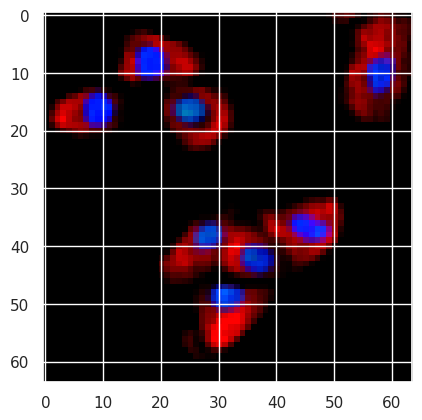

In [61]:
class HumanProteinDataset(Dataset):
    """
    Class for loading the dataset
    """
    def __init__(self, X, y, root_dir, transform=None):
        self.df = pd.DataFrame({
            'Image': X,
            'Label': [decode_target(l) for l in y]})
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        y = encode_label(img_label)
        img_fname = self.root_dir / (str(img_id) + ".png")
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, y

temp_dataset = HumanProteinDataset(
    X=df['Image'],
    y=df['Label'].apply(lambda x: x.split(' ')),
    root_dir=TRAIN_DIR,
    transform=TRANSFORM_TRAIN)

print(temp_dataset[0][0].shape)
print(temp_dataset[0][1].shape)
print(temp_dataset[0])

plt.imshow(temp_dataset[0][0].permute(1, 2, 0))

In [62]:
def F1_score(y_pred, y_true, threshold=THRESHOLD):
    """
    Computes the macro F1 score
    """
    y_true = y_true > threshold
    y_pred = nn.Sigmoid()(y_pred) > threshold

    # compute true/false positives/negatives per sample
    TP = (y_pred & y_true).sum(1).float()
    # TN = ((~y_pred) & (~y_true)).sum(1).float()
    FP = (y_pred & (~y_true)).sum(1).float()
    FN = ((~y_pred) & y_true).sum(1).float()

    # compute precision/recall per sample and average over batch
    precision = torch.mean( TP / (TP + FP + 1e-8) )
    recall = torch.mean( TP / (TP + FN + 1e-8) )
    F = 2 * ( (precision * recall) / (precision + recall + 1e-8))

    return F.detach()

# Model classes

Many models were initially tested which are not shown here. These include custom CNN models (with attention mechanisms) and several pre-trained models such as `efficientnet_b0`, `vgg16`, `vit_b_16`, and a `convnext-tiny-224` model fine-tuned on a multi-label Leukemia cell dataset (which I [found on Hugging Face](https://huggingface.co/JorgeGIT/finetuned-Leukemia-cell) and thought was interesting but not quite as powerful as I had hoped).

CNN-like models are the obvious choice for the task at hand since they are well-suited for image data where finding local patterns is key. The `ImageNet` pre-trained models tended to outperform custom models but also had longer training-times since they had so much more parameters.

Only the `efficientnet_v2_s` model was kept in the final notebook for brevity and because of computational contraints.

In [63]:
class MultilabelImageClassificationBase(nn.Module):
    """
    Base class for all models
    """
    def training_step(self, batch, epoch):
        # unpack batch, move to GPU and make predictions
        images, targets = batch
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        out = self(images)

        # compute and return weighted loss
        weight = WEIGHTS[epoch]
        weight = weight.to(DEVICE)
        return nn.BCEWithLogitsLoss(weight=weight)(out, targets)

    def validation_step(self, batch):
        # unpack batch, move to GPU and make predictions
        images, targets = batch
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        out = self(images)

        # compute loss and macro F1 score
        loss = nn.BCEWithLogitsLoss()(out, targets)
        score = F1_score(out, targets)
        return { 'val_loss': loss.detach(), 'val_score': score.detach() }

    def validation_epoch_end(self, outputs):
        # compute epoch-level scores
        batch_losses, batch_scores = zip(*[(x['val_loss'], x['val_score']) for x in outputs])
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_score = torch.stack(batch_scores).mean()
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}

    def epoch_end(self, epoch, result):
        # print epoch-level scores
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            (epoch + 1), result['train_loss'], result['val_loss'], result['val_score']))

class EfficientV2(MultilabelImageClassificationBase):
    """
    Model class based on pre-trained EfficientNetV2
    """
    def __init__(self):
        super().__init__()
        model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        model.classifier = nn.Dropout(0.1, inplace=True) # dropout is progressively increased
        self.net = model
        self.head = nn.Linear(1280, NUM_CLASSES) # BCEWithLogitsLoss already has Sigmoid (so no need to use it here)

    def forward(self, x):
        x = self.net(x)
        return self.head(x)

# Training / Validation loop

Several strategies for improving performance were applied on the level of the training loop. Some of these include:
- `weight_decay` and other efforts for reducing train-set over-fitting
- A rather low learning rate was chosen
- A scheduler to further lower the learning rate was useful for later epochs
- Label-representation weighted loss gives interesting results (train loss increasing while validation loss decreased)

In [64]:
def fit(epochs, lr, model, train_loader, val_loader, weight_decay=WEIGHT_DECAY):
    torch.cuda.empty_cache()
    model = model.to(DEVICE)
    history = []

    # optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=PATIENCE, verbose=True)

    for epoch in range(epochs):
        # Set progressive learning parameters for this epoch
        TRANSFORM_TEST.transforms[1].size = list((sizes[epoch], sizes[epoch]))
        TRANSFORM_TRAIN.transforms[1].size = list((sizes[epoch], sizes[epoch]))
        TRANSFORM_TRAIN.transforms[2].p = flip_probs[epoch]
        TRANSFORM_TRAIN.transforms[3].p = flip_probs[epoch]
        TRANSFORM_TRAIN.transforms[4].degrees = [rotations[epoch], rotations[epoch]]
        TRANSFORM_TRAIN.transforms[5].size = (sizes[epoch], sizes[epoch])
        TRANSFORM_TRAIN.transforms[5].scale = (scales[epoch], 1.0)
        model.net.classifier.p = dropouts[epoch]

        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            loss = model.training_step(batch, epoch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        val_outputs = [model.validation_step(batch) for batch in val_loader]
        result = model.validation_epoch_end(val_outputs)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        scheduler.step(result['val_loss'])

        model.epoch_end(epoch, result)
        history.append(result)

    return history, model

def plot_history(history):
    """
    Plots the train and validation loss and validation F1 score
    """
    train_losses = [x.get('train_loss') for x in history]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    val_losses = [x['val_loss'] for x in history]
    val_scores = [x['val_score'] for x in history]

    ax1.plot(train_losses, '-bx')
    ax1.plot(val_losses, '-rx')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend(['Training (progressively weighted)', 'Validation'])
    ax1.title.set_text('Loss vs. No. of epochs')

    ax2.plot(val_scores, '-rx')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('F1 score')
    ax2.title.set_text('Validation F1 score vs. No. of epochs')

    plt.show()

# Trainig the models over multiple folds and saving the test predictions

To get the best results I could generate I chose to create an `efficientnet_v2_s` ensemble where different partitions of the data were used for training/validation.

Training EfficientNetV2 on fold 1


100%|██████████| 432/432 [02:04<00:00,  3.48it/s]


Epoch [1], train_loss: 0.3912, val_loss: 0.3341, val_score: 0.2955


100%|██████████| 432/432 [02:08<00:00,  3.35it/s]


Epoch [2], train_loss: 0.3620, val_loss: 0.3235, val_score: 0.3882


100%|██████████| 432/432 [02:19<00:00,  3.10it/s]


Epoch [3], train_loss: 0.3717, val_loss: 0.3085, val_score: 0.4493


100%|██████████| 432/432 [02:18<00:00,  3.11it/s]


Epoch [4], train_loss: 0.3778, val_loss: 0.2948, val_score: 0.4753


100%|██████████| 432/432 [02:15<00:00,  3.18it/s]


Epoch [5], train_loss: 0.3827, val_loss: 0.2762, val_score: 0.5313


100%|██████████| 432/432 [02:17<00:00,  3.13it/s]


Epoch [6], train_loss: 0.3884, val_loss: 0.2684, val_score: 0.5058


100%|██████████| 432/432 [02:29<00:00,  2.90it/s]


Epoch [7], train_loss: 0.3870, val_loss: 0.2519, val_score: 0.5807


100%|██████████| 432/432 [02:30<00:00,  2.87it/s]


Epoch [8], train_loss: 0.3931, val_loss: 0.2496, val_score: 0.5935


100%|██████████| 432/432 [02:33<00:00,  2.82it/s]


Epoch [9], train_loss: 0.3931, val_loss: 0.2374, val_score: 0.6266


100%|██████████| 432/432 [02:32<00:00,  2.82it/s]


Epoch [10], train_loss: 0.3971, val_loss: 0.2344, val_score: 0.6422


100%|██████████| 432/432 [02:40<00:00,  2.69it/s]


Epoch [11], train_loss: 0.4007, val_loss: 0.2205, val_score: 0.6848


100%|██████████| 432/432 [02:42<00:00,  2.66it/s]


Epoch [12], train_loss: 0.4108, val_loss: 0.2201, val_score: 0.6811


100%|██████████| 432/432 [02:58<00:00,  2.42it/s]


Epoch [13], train_loss: 0.4164, val_loss: 0.2230, val_score: 0.6510


100%|██████████| 432/432 [02:58<00:00,  2.42it/s]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-05.
Epoch [14], train_loss: 0.4230, val_loss: 0.2321, val_score: 0.6219


100%|██████████| 432/432 [03:13<00:00,  2.23it/s]


Epoch [15], train_loss: 0.4206, val_loss: 0.2110, val_score: 0.6873


100%|██████████| 432/432 [03:12<00:00,  2.24it/s]


Epoch [16], train_loss: 0.4215, val_loss: 0.2061, val_score: 0.6877


100%|██████████| 432/432 [03:19<00:00,  2.16it/s]


Epoch [17], train_loss: 0.4319, val_loss: 0.2105, val_score: 0.6675


100%|██████████| 432/432 [03:16<00:00,  2.20it/s]


Epoch 00018: reducing learning rate of group 0 to 2.5000e-05.
Epoch [18], train_loss: 0.4422, val_loss: 0.2230, val_score: 0.6607


100%|██████████| 432/432 [03:10<00:00,  2.27it/s]


Epoch [19], train_loss: 0.4395, val_loss: 0.1968, val_score: 0.7214


100%|██████████| 432/432 [02:57<00:00,  2.43it/s]


Epoch [20], train_loss: 0.4436, val_loss: 0.1895, val_score: 0.7460


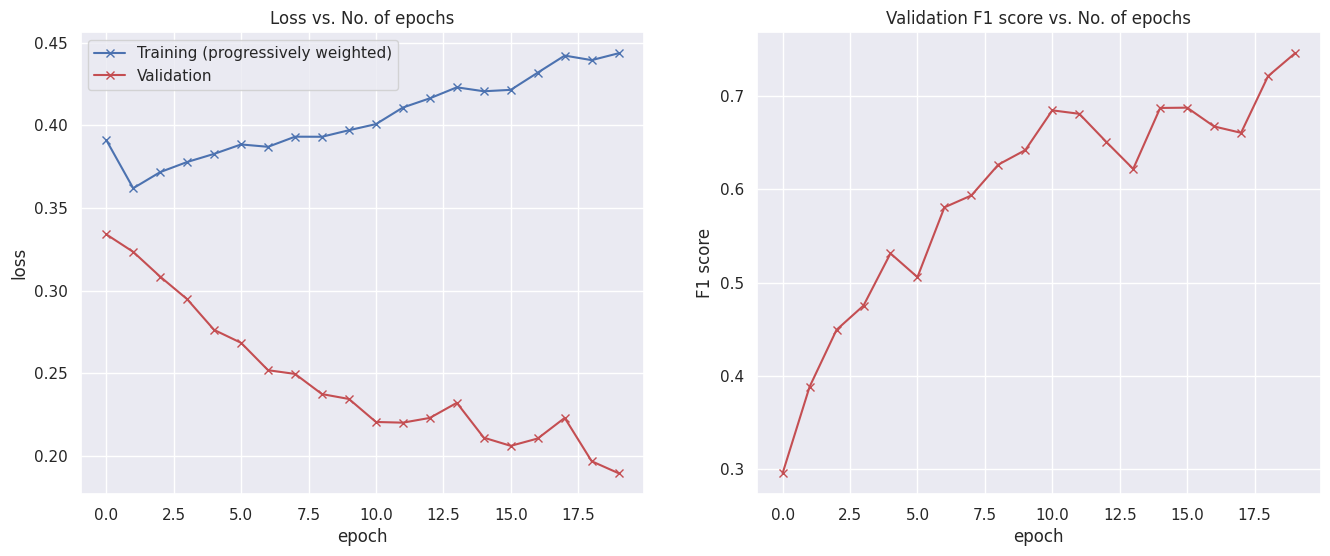

Training EfficientNetV2 on fold 2


100%|██████████| 433/433 [02:10<00:00,  3.32it/s]


Epoch [1], train_loss: 0.3914, val_loss: 0.3371, val_score: 0.3233


100%|██████████| 433/433 [02:16<00:00,  3.17it/s]


Epoch [2], train_loss: 0.3610, val_loss: 0.3299, val_score: 0.3295


100%|██████████| 433/433 [02:23<00:00,  3.02it/s]


Epoch [3], train_loss: 0.3703, val_loss: 0.3116, val_score: 0.4099


100%|██████████| 433/433 [02:24<00:00,  3.00it/s]


Epoch [4], train_loss: 0.3775, val_loss: 0.3001, val_score: 0.4675


100%|██████████| 433/433 [02:21<00:00,  3.05it/s]


Epoch [5], train_loss: 0.3834, val_loss: 0.2856, val_score: 0.5086


100%|██████████| 433/433 [02:21<00:00,  3.07it/s]


Epoch [6], train_loss: 0.3902, val_loss: 0.2749, val_score: 0.5476


100%|██████████| 433/433 [02:33<00:00,  2.82it/s]


Epoch [7], train_loss: 0.3914, val_loss: 0.2575, val_score: 0.5680


100%|██████████| 433/433 [02:34<00:00,  2.79it/s]


Epoch [8], train_loss: 0.3943, val_loss: 0.2612, val_score: 0.5763


100%|██████████| 433/433 [02:39<00:00,  2.72it/s]


Epoch [9], train_loss: 0.3962, val_loss: 0.2519, val_score: 0.6020


100%|██████████| 433/433 [02:42<00:00,  2.67it/s]


Epoch [10], train_loss: 0.3993, val_loss: 0.2460, val_score: 0.5868


100%|██████████| 433/433 [02:53<00:00,  2.50it/s]


Epoch [11], train_loss: 0.4045, val_loss: 0.2317, val_score: 0.6426


100%|██████████| 433/433 [02:53<00:00,  2.49it/s]


Epoch [12], train_loss: 0.4110, val_loss: 0.2413, val_score: 0.6248


100%|██████████| 433/433 [03:09<00:00,  2.29it/s]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-05.
Epoch [13], train_loss: 0.4159, val_loss: 0.2351, val_score: 0.6539


100%|██████████| 433/433 [03:04<00:00,  2.35it/s]


Epoch [14], train_loss: 0.4059, val_loss: 0.2186, val_score: 0.6528


100%|██████████| 433/433 [03:20<00:00,  2.16it/s]


Epoch [15], train_loss: 0.4167, val_loss: 0.2197, val_score: 0.6741


100%|██████████| 433/433 [03:17<00:00,  2.19it/s]


Epoch 00016: reducing learning rate of group 0 to 2.5000e-05.
Epoch [16], train_loss: 0.4244, val_loss: 0.2219, val_score: 0.6407


100%|██████████| 433/433 [03:23<00:00,  2.12it/s]


Epoch [17], train_loss: 0.4233, val_loss: 0.2184, val_score: 0.6510


100%|██████████| 433/433 [03:20<00:00,  2.16it/s]


Epoch [18], train_loss: 0.4279, val_loss: 0.2231, val_score: 0.6430


100%|██████████| 433/433 [03:16<00:00,  2.21it/s]


Epoch [19], train_loss: 0.4386, val_loss: 0.2145, val_score: 0.6720


100%|██████████| 433/433 [03:02<00:00,  2.37it/s]


Epoch [20], train_loss: 0.4454, val_loss: 0.2008, val_score: 0.7057


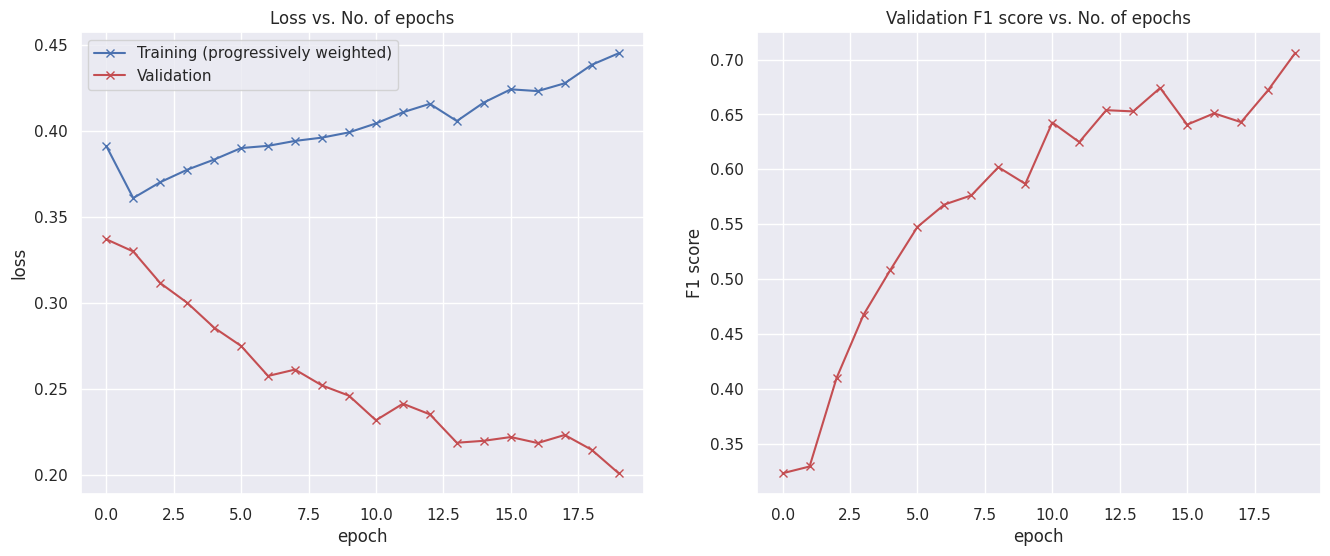

Training EfficientNetV2 on fold 3


100%|██████████| 433/433 [02:13<00:00,  3.25it/s]


Epoch [1], train_loss: 0.3875, val_loss: 0.3333, val_score: 0.3795


100%|██████████| 433/433 [02:19<00:00,  3.10it/s]


Epoch [2], train_loss: 0.3578, val_loss: 0.3295, val_score: 0.3898


100%|██████████| 433/433 [02:31<00:00,  2.86it/s]


Epoch [3], train_loss: 0.3669, val_loss: 0.3081, val_score: 0.4299


100%|██████████| 433/433 [02:32<00:00,  2.85it/s]


Epoch [4], train_loss: 0.3725, val_loss: 0.2956, val_score: 0.4537


100%|██████████| 433/433 [02:28<00:00,  2.91it/s]


Epoch [5], train_loss: 0.3781, val_loss: 0.2787, val_score: 0.5080


100%|██████████| 433/433 [02:30<00:00,  2.88it/s]


Epoch [6], train_loss: 0.3838, val_loss: 0.2756, val_score: 0.5266


100%|██████████| 433/433 [02:44<00:00,  2.64it/s]


Epoch [7], train_loss: 0.3845, val_loss: 0.2649, val_score: 0.5763


100%|██████████| 433/433 [02:45<00:00,  2.62it/s]


Epoch [8], train_loss: 0.3905, val_loss: 0.2555, val_score: 0.6016


100%|██████████| 433/433 [02:46<00:00,  2.60it/s]


Epoch [9], train_loss: 0.3898, val_loss: 0.2346, val_score: 0.6097


100%|██████████| 433/433 [02:46<00:00,  2.59it/s]


Epoch [10], train_loss: 0.3972, val_loss: 0.2364, val_score: 0.6099


100%|██████████| 433/433 [02:55<00:00,  2.46it/s]


Epoch [11], train_loss: 0.4006, val_loss: 0.2286, val_score: 0.6481


100%|██████████| 433/433 [02:56<00:00,  2.45it/s]


Epoch [12], train_loss: 0.4105, val_loss: 0.2312, val_score: 0.6272


100%|██████████| 433/433 [03:11<00:00,  2.27it/s]


Epoch [13], train_loss: 0.4169, val_loss: 0.2185, val_score: 0.6579


100%|██████████| 433/433 [03:11<00:00,  2.26it/s]


Epoch [14], train_loss: 0.4286, val_loss: 0.2215, val_score: 0.6632


100%|██████████| 433/433 [03:24<00:00,  2.12it/s]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-05.
Epoch [15], train_loss: 0.4398, val_loss: 0.2216, val_score: 0.6597


100%|██████████| 433/433 [03:24<00:00,  2.12it/s]


Epoch [16], train_loss: 0.4254, val_loss: 0.2139, val_score: 0.6887


100%|██████████| 433/433 [03:32<00:00,  2.04it/s]


Epoch [17], train_loss: 0.4343, val_loss: 0.2154, val_score: 0.6686


100%|██████████| 433/433 [03:28<00:00,  2.08it/s]


Epoch [18], train_loss: 0.4452, val_loss: 0.2099, val_score: 0.7014


100%|██████████| 433/433 [03:24<00:00,  2.12it/s]


Epoch [19], train_loss: 0.4547, val_loss: 0.2048, val_score: 0.7179


100%|██████████| 433/433 [03:16<00:00,  2.20it/s]


Epoch [20], train_loss: 0.4648, val_loss: 0.2050, val_score: 0.6893


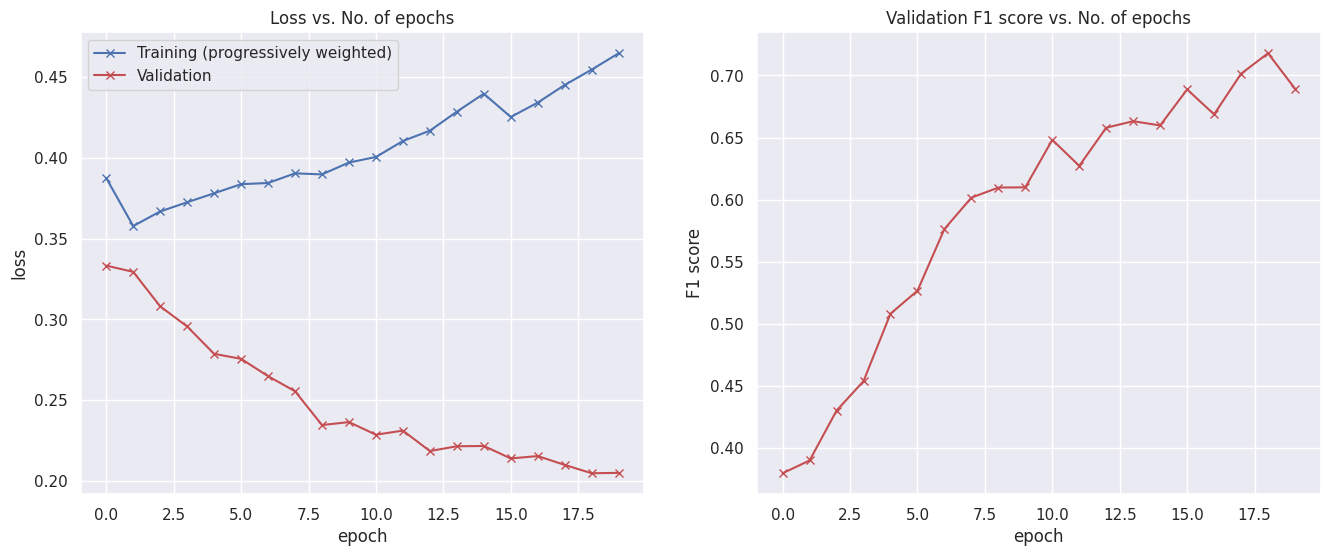

Training EfficientNetV2 on fold 4


100%|██████████| 434/434 [02:25<00:00,  2.97it/s]


Epoch [1], train_loss: 0.4019, val_loss: 0.3390, val_score: 0.3267


100%|██████████| 434/434 [02:29<00:00,  2.90it/s]


Epoch [2], train_loss: 0.3635, val_loss: 0.3310, val_score: 0.3173


100%|██████████| 434/434 [02:40<00:00,  2.71it/s]


Epoch [3], train_loss: 0.3708, val_loss: 0.3151, val_score: 0.3957


100%|██████████| 434/434 [02:41<00:00,  2.68it/s]


Epoch [4], train_loss: 0.3798, val_loss: 0.3020, val_score: 0.4548


100%|██████████| 434/434 [02:39<00:00,  2.73it/s]


Epoch [5], train_loss: 0.3843, val_loss: 0.2888, val_score: 0.5141


100%|██████████| 434/434 [02:39<00:00,  2.72it/s]


Epoch [6], train_loss: 0.3910, val_loss: 0.2778, val_score: 0.5361


100%|██████████| 434/434 [02:52<00:00,  2.51it/s]


Epoch [7], train_loss: 0.3925, val_loss: 0.2667, val_score: 0.5728


100%|██████████| 434/434 [02:53<00:00,  2.50it/s]


Epoch [8], train_loss: 0.3959, val_loss: 0.2520, val_score: 0.6220


100%|██████████| 434/434 [02:56<00:00,  2.45it/s]


Epoch [9], train_loss: 0.3964, val_loss: 0.2429, val_score: 0.6256


100%|██████████| 434/434 [02:55<00:00,  2.47it/s]


Epoch [10], train_loss: 0.4009, val_loss: 0.2454, val_score: 0.6247


100%|██████████| 434/434 [03:05<00:00,  2.33it/s]


Epoch [11], train_loss: 0.4039, val_loss: 0.2297, val_score: 0.6314


100%|██████████| 434/434 [03:07<00:00,  2.32it/s]


Epoch [12], train_loss: 0.4119, val_loss: 0.2417, val_score: 0.6287


100%|██████████| 434/434 [03:19<00:00,  2.18it/s]


Epoch [13], train_loss: 0.4180, val_loss: 0.2254, val_score: 0.6613


100%|██████████| 434/434 [03:18<00:00,  2.19it/s]


Epoch [14], train_loss: 0.4295, val_loss: 0.2263, val_score: 0.6543


100%|██████████| 434/434 [03:33<00:00,  2.03it/s]


Epoch [15], train_loss: 0.4402, val_loss: 0.2217, val_score: 0.6811


100%|██████████| 434/434 [03:35<00:00,  2.01it/s]


Epoch [16], train_loss: 0.4487, val_loss: 0.2181, val_score: 0.6645


100%|██████████| 434/434 [03:41<00:00,  1.96it/s]


Epoch [17], train_loss: 0.4592, val_loss: 0.2029, val_score: 0.7315


100%|██████████| 434/434 [03:37<00:00,  2.00it/s]


Epoch [18], train_loss: 0.4705, val_loss: 0.2174, val_score: 0.6687


100%|██████████| 434/434 [03:31<00:00,  2.05it/s]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.
Epoch [19], train_loss: 0.4811, val_loss: 0.2077, val_score: 0.7124


100%|██████████| 434/434 [03:23<00:00,  2.13it/s]


Epoch [20], train_loss: 0.4633, val_loss: 0.1877, val_score: 0.7457


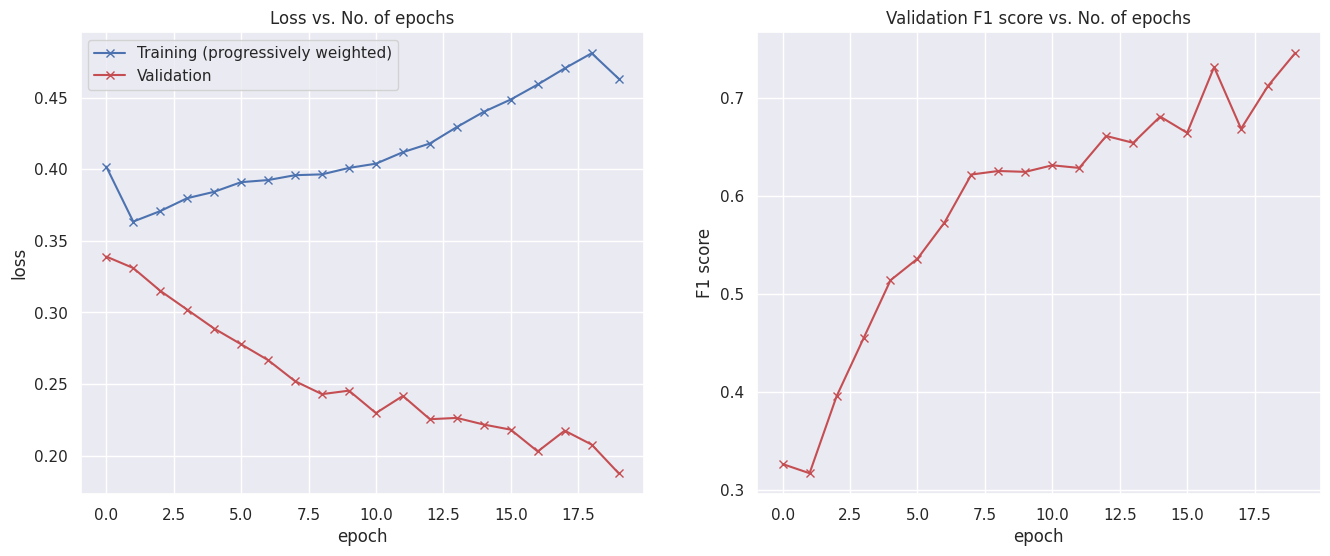

Training EfficientNetV2 on fold 5


100%|██████████| 433/433 [02:36<00:00,  2.77it/s]


Epoch [1], train_loss: 0.3927, val_loss: 0.3413, val_score: 0.2772


100%|██████████| 433/433 [02:40<00:00,  2.69it/s]


Epoch [2], train_loss: 0.3621, val_loss: 0.3310, val_score: 0.3455


100%|██████████| 433/433 [02:53<00:00,  2.49it/s]


Epoch [3], train_loss: 0.3721, val_loss: 0.3092, val_score: 0.4194


100%|██████████| 433/433 [02:54<00:00,  2.49it/s]


Epoch [4], train_loss: 0.3781, val_loss: 0.3025, val_score: 0.4260


100%|██████████| 433/433 [02:49<00:00,  2.55it/s]


Epoch [5], train_loss: 0.3831, val_loss: 0.2816, val_score: 0.5494


100%|██████████| 433/433 [02:49<00:00,  2.55it/s]


Epoch [6], train_loss: 0.3874, val_loss: 0.2756, val_score: 0.5371


100%|██████████| 433/433 [03:00<00:00,  2.40it/s]


Epoch [7], train_loss: 0.3877, val_loss: 0.2680, val_score: 0.5715


100%|██████████| 433/433 [03:01<00:00,  2.38it/s]


Epoch [8], train_loss: 0.3931, val_loss: 0.2604, val_score: 0.5795


100%|██████████| 433/433 [03:03<00:00,  2.36it/s]


Epoch [9], train_loss: 0.3942, val_loss: 0.2586, val_score: 0.5894


100%|██████████| 433/433 [03:04<00:00,  2.34it/s]


Epoch [10], train_loss: 0.3971, val_loss: 0.2367, val_score: 0.6670


100%|██████████| 433/433 [03:15<00:00,  2.21it/s]


Epoch [11], train_loss: 0.4000, val_loss: 0.2356, val_score: 0.6364


100%|██████████| 433/433 [03:18<00:00,  2.19it/s]


Epoch [12], train_loss: 0.4081, val_loss: 0.2318, val_score: 0.6509


100%|██████████| 433/433 [03:28<00:00,  2.08it/s]


Epoch [13], train_loss: 0.4155, val_loss: 0.2335, val_score: 0.6439


100%|██████████| 433/433 [03:27<00:00,  2.09it/s]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-05.
Epoch [14], train_loss: 0.4264, val_loss: 0.2401, val_score: 0.6217


100%|██████████| 433/433 [03:42<00:00,  1.95it/s]


Epoch [15], train_loss: 0.4185, val_loss: 0.2184, val_score: 0.6818


100%|██████████| 433/433 [03:46<00:00,  1.91it/s]


Epoch [16], train_loss: 0.4233, val_loss: 0.2182, val_score: 0.6929


100%|██████████| 433/433 [03:58<00:00,  1.82it/s]


Epoch [17], train_loss: 0.4329, val_loss: 0.2254, val_score: 0.6672


100%|██████████| 433/433 [03:51<00:00,  1.87it/s]


Epoch 00018: reducing learning rate of group 0 to 2.5000e-05.
Epoch [18], train_loss: 0.4442, val_loss: 0.2209, val_score: 0.6918


100%|██████████| 433/433 [03:54<00:00,  1.85it/s]


Epoch [19], train_loss: 0.4407, val_loss: 0.2064, val_score: 0.7112


100%|██████████| 433/433 [03:39<00:00,  1.97it/s]


Epoch [20], train_loss: 0.4471, val_loss: 0.1983, val_score: 0.7162


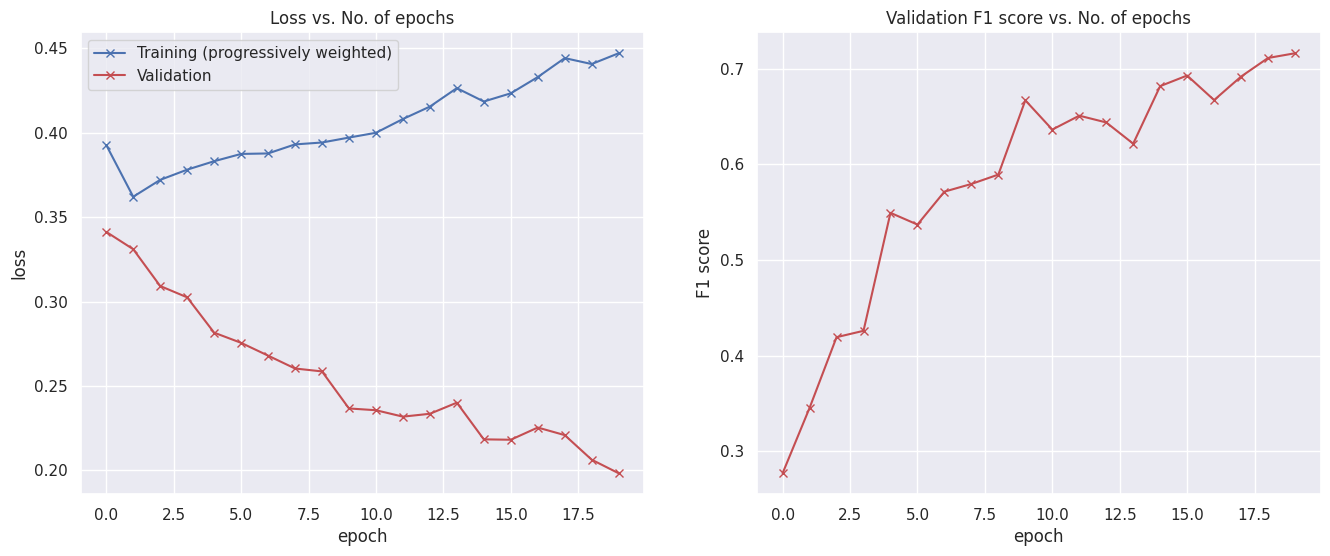

Training EfficientNetV2 on fold 6


100%|██████████| 434/434 [02:51<00:00,  2.53it/s]


Epoch [1], train_loss: 0.3828, val_loss: 0.3435, val_score: 0.3524


100%|██████████| 434/434 [02:53<00:00,  2.50it/s]


Epoch [2], train_loss: 0.3581, val_loss: 0.3301, val_score: 0.3561


100%|██████████| 434/434 [03:07<00:00,  2.32it/s]


Epoch [3], train_loss: 0.3669, val_loss: 0.3121, val_score: 0.4003


100%|██████████| 434/434 [03:08<00:00,  2.30it/s]


Epoch [4], train_loss: 0.3739, val_loss: 0.2997, val_score: 0.4505


100%|██████████| 434/434 [03:01<00:00,  2.39it/s]


Epoch [5], train_loss: 0.3793, val_loss: 0.2783, val_score: 0.5147


100%|██████████| 434/434 [02:59<00:00,  2.42it/s]


Epoch [6], train_loss: 0.3853, val_loss: 0.2745, val_score: 0.5476


100%|██████████| 434/434 [03:11<00:00,  2.26it/s]


Epoch [7], train_loss: 0.3854, val_loss: 0.2622, val_score: 0.5727


100%|██████████| 434/434 [03:14<00:00,  2.24it/s]


Epoch [8], train_loss: 0.3900, val_loss: 0.2513, val_score: 0.5926


100%|██████████| 434/434 [03:19<00:00,  2.17it/s]


Epoch [9], train_loss: 0.3908, val_loss: 0.2405, val_score: 0.6172


100%|██████████| 434/434 [03:19<00:00,  2.18it/s]


Epoch [10], train_loss: 0.3956, val_loss: 0.2538, val_score: 0.6051


100%|██████████| 434/434 [03:28<00:00,  2.09it/s]


Epoch [11], train_loss: 0.3988, val_loss: 0.2316, val_score: 0.6647


100%|██████████| 434/434 [03:29<00:00,  2.07it/s]


Epoch [12], train_loss: 0.4081, val_loss: 0.2292, val_score: 0.6436


100%|██████████| 434/434 [03:41<00:00,  1.96it/s]


Epoch [13], train_loss: 0.4152, val_loss: 0.2314, val_score: 0.6388


100%|██████████| 434/434 [03:44<00:00,  1.93it/s]


Epoch [14], train_loss: 0.4265, val_loss: 0.2215, val_score: 0.6673


100%|██████████| 434/434 [04:04<00:00,  1.77it/s]


Epoch [15], train_loss: 0.4356, val_loss: 0.2204, val_score: 0.6695


100%|██████████| 434/434 [04:10<00:00,  1.73it/s]


Epoch [16], train_loss: 0.4458, val_loss: 0.2257, val_score: 0.6570


100%|██████████| 434/434 [04:16<00:00,  1.69it/s]


Epoch [17], train_loss: 0.4558, val_loss: 0.2173, val_score: 0.6641


100%|██████████| 434/434 [04:13<00:00,  1.71it/s]


Epoch [18], train_loss: 0.4668, val_loss: 0.2147, val_score: 0.6808


100%|██████████| 434/434 [04:12<00:00,  1.72it/s]


Epoch [19], train_loss: 0.4791, val_loss: 0.2047, val_score: 0.6770


100%|██████████| 434/434 [03:56<00:00,  1.84it/s]


Epoch [20], train_loss: 0.4871, val_loss: 0.2064, val_score: 0.7046


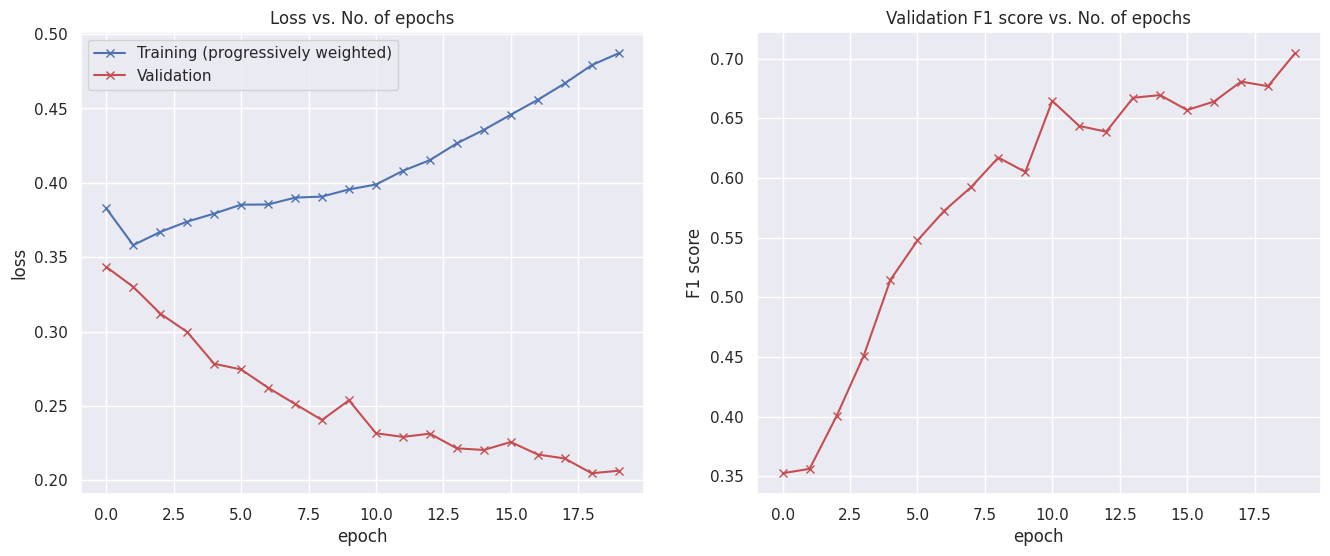

Training EfficientNetV2 on fold 7


100%|██████████| 434/434 [03:03<00:00,  2.36it/s]


Epoch [1], train_loss: 0.3917, val_loss: 0.3389, val_score: 0.3721


100%|██████████| 434/434 [03:10<00:00,  2.28it/s]


Epoch [2], train_loss: 0.3615, val_loss: 0.3275, val_score: 0.3740


100%|██████████| 434/434 [03:23<00:00,  2.13it/s]


Epoch [3], train_loss: 0.3725, val_loss: 0.3145, val_score: 0.4462


100%|██████████| 434/434 [03:24<00:00,  2.12it/s]


Epoch [4], train_loss: 0.3788, val_loss: 0.3045, val_score: 0.4609


100%|██████████| 434/434 [03:19<00:00,  2.17it/s]


Epoch [5], train_loss: 0.3836, val_loss: 0.2858, val_score: 0.5472


100%|██████████| 434/434 [03:19<00:00,  2.17it/s]


Epoch [6], train_loss: 0.3896, val_loss: 0.2722, val_score: 0.5586


100%|██████████| 434/434 [03:32<00:00,  2.04it/s]


Epoch [7], train_loss: 0.3892, val_loss: 0.2575, val_score: 0.5928


100%|██████████| 434/434 [03:35<00:00,  2.02it/s]


Epoch [8], train_loss: 0.3935, val_loss: 0.2509, val_score: 0.6015


100%|██████████| 434/434 [03:38<00:00,  1.99it/s]


Epoch [9], train_loss: 0.3940, val_loss: 0.2424, val_score: 0.6262


100%|██████████| 434/434 [03:38<00:00,  1.98it/s]


Epoch [10], train_loss: 0.4001, val_loss: 0.2338, val_score: 0.6476


100%|██████████| 434/434 [03:50<00:00,  1.88it/s]


Epoch [11], train_loss: 0.4036, val_loss: 0.2379, val_score: 0.6421


100%|██████████| 434/434 [03:46<00:00,  1.91it/s]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-05.
Epoch [12], train_loss: 0.4128, val_loss: 0.2352, val_score: 0.6352


100%|██████████| 434/434 [04:02<00:00,  1.79it/s]


Epoch [13], train_loss: 0.4002, val_loss: 0.2343, val_score: 0.6460


100%|██████████| 434/434 [04:05<00:00,  1.77it/s]


Epoch [14], train_loss: 0.4107, val_loss: 0.2206, val_score: 0.6716


100%|██████████| 434/434 [04:20<00:00,  1.67it/s]


Epoch [15], train_loss: 0.4220, val_loss: 0.2337, val_score: 0.6366


100%|██████████| 434/434 [04:19<00:00,  1.67it/s]


Epoch 00016: reducing learning rate of group 0 to 2.5000e-05.
Epoch [16], train_loss: 0.4278, val_loss: 0.2292, val_score: 0.6563


100%|██████████| 434/434 [04:27<00:00,  1.62it/s]


Epoch [17], train_loss: 0.4237, val_loss: 0.2190, val_score: 0.6776


100%|██████████| 434/434 [04:25<00:00,  1.64it/s]


Epoch [18], train_loss: 0.4326, val_loss: 0.2087, val_score: 0.6931


100%|██████████| 434/434 [04:19<00:00,  1.67it/s]


Epoch [19], train_loss: 0.4403, val_loss: 0.1999, val_score: 0.7118


100%|██████████| 434/434 [04:06<00:00,  1.76it/s]


Epoch [20], train_loss: 0.4488, val_loss: 0.1952, val_score: 0.7363


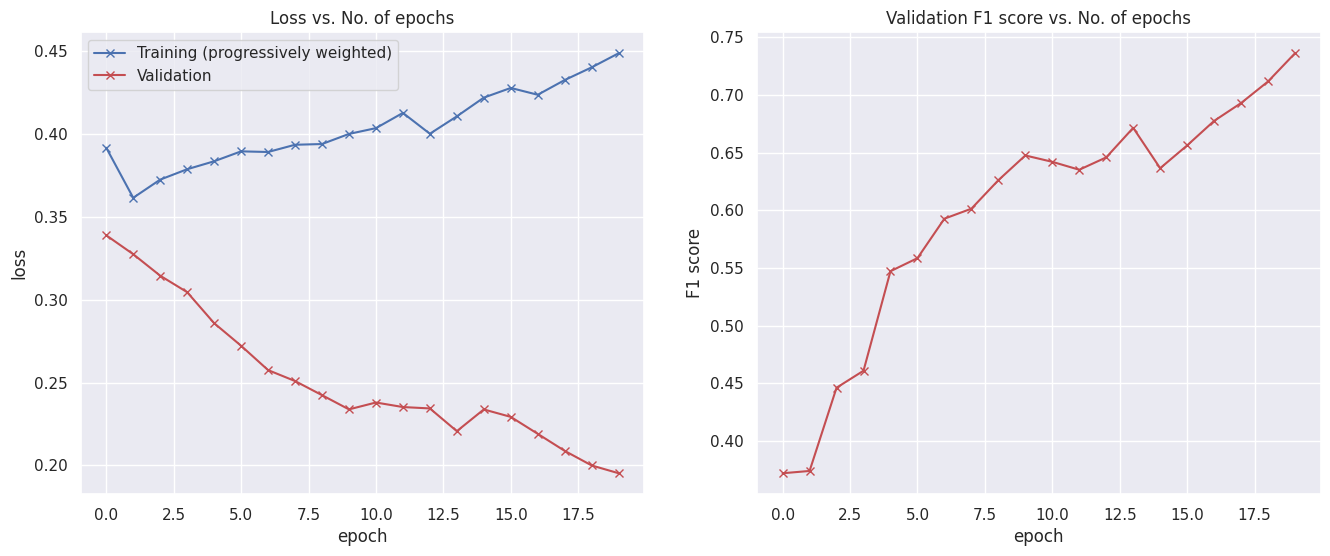

Training EfficientNetV2 on fold 8


100%|██████████| 433/433 [03:13<00:00,  2.24it/s]


Epoch [1], train_loss: 0.3848, val_loss: 0.3797, val_score: 0.3442


100%|██████████| 433/433 [03:18<00:00,  2.18it/s]


Epoch [2], train_loss: 0.3600, val_loss: 0.3270, val_score: 0.3664


100%|██████████| 433/433 [03:29<00:00,  2.07it/s]


Epoch [3], train_loss: 0.3694, val_loss: 0.3063, val_score: 0.3844


100%|██████████| 433/433 [03:30<00:00,  2.06it/s]


Epoch [4], train_loss: 0.3780, val_loss: 0.2984, val_score: 0.4572


100%|██████████| 433/433 [03:27<00:00,  2.08it/s]


Epoch [5], train_loss: 0.3843, val_loss: 0.2754, val_score: 0.5016


100%|██████████| 433/433 [03:29<00:00,  2.07it/s]


Epoch [6], train_loss: 0.3878, val_loss: 0.2648, val_score: 0.5544


100%|██████████| 433/433 [03:43<00:00,  1.94it/s]


Epoch [7], train_loss: 0.3910, val_loss: 0.2550, val_score: 0.5816


100%|██████████| 433/433 [03:43<00:00,  1.94it/s]


Epoch [8], train_loss: 0.3949, val_loss: 0.2450, val_score: 0.6342


100%|██████████| 433/433 [03:50<00:00,  1.88it/s]


Epoch [9], train_loss: 0.3957, val_loss: 0.2366, val_score: 0.6568


100%|██████████| 433/433 [03:47<00:00,  1.90it/s]


Epoch [10], train_loss: 0.3987, val_loss: 0.2245, val_score: 0.6623


100%|██████████| 433/433 [03:54<00:00,  1.84it/s]


Epoch [11], train_loss: 0.4013, val_loss: 0.2251, val_score: 0.6600


100%|██████████| 433/433 [03:51<00:00,  1.87it/s]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-05.
Epoch [12], train_loss: 0.4116, val_loss: 0.2322, val_score: 0.6155


100%|██████████| 433/433 [04:05<00:00,  1.77it/s]


Epoch [13], train_loss: 0.4008, val_loss: 0.2260, val_score: 0.6431


100%|██████████| 433/433 [04:01<00:00,  1.79it/s]


Epoch 00014: reducing learning rate of group 0 to 2.5000e-05.
Epoch [14], train_loss: 0.4074, val_loss: 0.2256, val_score: 0.6313


100%|██████████| 433/433 [04:12<00:00,  1.71it/s]


Epoch [15], train_loss: 0.4078, val_loss: 0.2155, val_score: 0.6726


100%|██████████| 433/433 [04:10<00:00,  1.73it/s]


Epoch [16], train_loss: 0.4157, val_loss: 0.2145, val_score: 0.6684


100%|██████████| 433/433 [04:15<00:00,  1.70it/s]


Epoch [17], train_loss: 0.4270, val_loss: 0.2121, val_score: 0.6609


100%|██████████| 433/433 [04:13<00:00,  1.71it/s]


Epoch [18], train_loss: 0.4350, val_loss: 0.2126, val_score: 0.6722


100%|██████████| 433/433 [04:12<00:00,  1.71it/s]


Epoch [19], train_loss: 0.4464, val_loss: 0.2058, val_score: 0.7002


100%|██████████| 433/433 [04:00<00:00,  1.80it/s]


Epoch [20], train_loss: 0.4524, val_loss: 0.1967, val_score: 0.7258


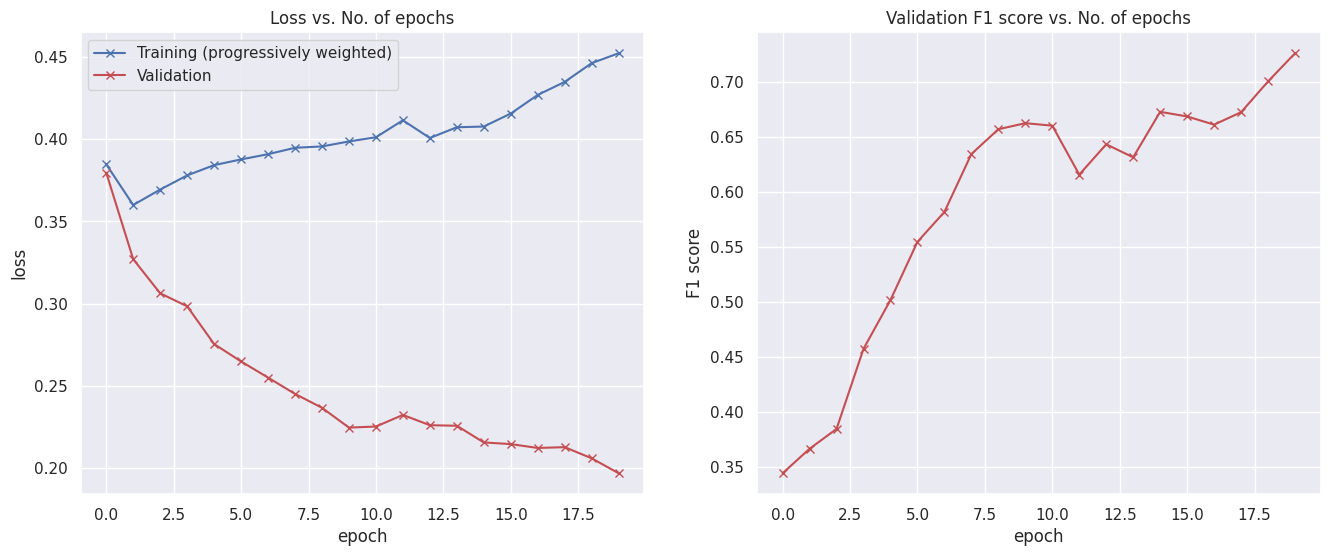

Training EfficientNetV2 on fold 9


100%|██████████| 433/433 [03:11<00:00,  2.26it/s]


Epoch [1], train_loss: 0.3935, val_loss: 0.3390, val_score: 0.3161


100%|██████████| 433/433 [03:16<00:00,  2.21it/s]


Epoch [2], train_loss: 0.3612, val_loss: 0.3293, val_score: 0.3550


100%|██████████| 433/433 [03:27<00:00,  2.08it/s]


Epoch [3], train_loss: 0.3707, val_loss: 0.3188, val_score: 0.4143


100%|██████████| 433/433 [03:29<00:00,  2.06it/s]


Epoch [4], train_loss: 0.3771, val_loss: 0.3076, val_score: 0.3933


100%|██████████| 433/433 [03:26<00:00,  2.10it/s]


Epoch [5], train_loss: 0.3864, val_loss: 0.2872, val_score: 0.5031


100%|██████████| 433/433 [03:27<00:00,  2.08it/s]


Epoch [6], train_loss: 0.3899, val_loss: 0.2809, val_score: 0.5412


100%|██████████| 433/433 [03:39<00:00,  1.97it/s]


Epoch [7], train_loss: 0.3912, val_loss: 0.2685, val_score: 0.5466


100%|██████████| 433/433 [03:43<00:00,  1.93it/s]


Epoch [8], train_loss: 0.3967, val_loss: 0.2555, val_score: 0.5717


100%|██████████| 433/433 [03:47<00:00,  1.90it/s]


Epoch [9], train_loss: 0.3982, val_loss: 0.2482, val_score: 0.5957


100%|██████████| 433/433 [03:44<00:00,  1.93it/s]


Epoch [10], train_loss: 0.4006, val_loss: 0.2420, val_score: 0.6192


100%|██████████| 433/433 [03:59<00:00,  1.81it/s]


Epoch [11], train_loss: 0.4034, val_loss: 0.2313, val_score: 0.6335


100%|██████████| 433/433 [03:55<00:00,  1.84it/s]


Epoch [12], train_loss: 0.4091, val_loss: 0.2303, val_score: 0.6555


100%|██████████| 433/433 [04:10<00:00,  1.73it/s]


Epoch [13], train_loss: 0.4186, val_loss: 0.2409, val_score: 0.5901


100%|██████████| 433/433 [04:09<00:00,  1.73it/s]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-05.
Epoch [14], train_loss: 0.4273, val_loss: 0.2338, val_score: 0.6082


100%|██████████| 433/433 [04:25<00:00,  1.63it/s]


Epoch [15], train_loss: 0.4185, val_loss: 0.2229, val_score: 0.6434


100%|██████████| 433/433 [04:23<00:00,  1.64it/s]


Epoch [16], train_loss: 0.4215, val_loss: 0.2363, val_score: 0.5967


100%|██████████| 433/433 [04:33<00:00,  1.58it/s]


Epoch [17], train_loss: 0.4338, val_loss: 0.2147, val_score: 0.6636


100%|██████████| 433/433 [04:31<00:00,  1.59it/s]


Epoch [18], train_loss: 0.4415, val_loss: 0.2183, val_score: 0.6821


100%|██████████| 433/433 [04:25<00:00,  1.63it/s]


Epoch [19], train_loss: 0.4544, val_loss: 0.2147, val_score: 0.6739


100%|██████████| 433/433 [04:10<00:00,  1.73it/s]


Epoch [20], train_loss: 0.4613, val_loss: 0.2072, val_score: 0.6754


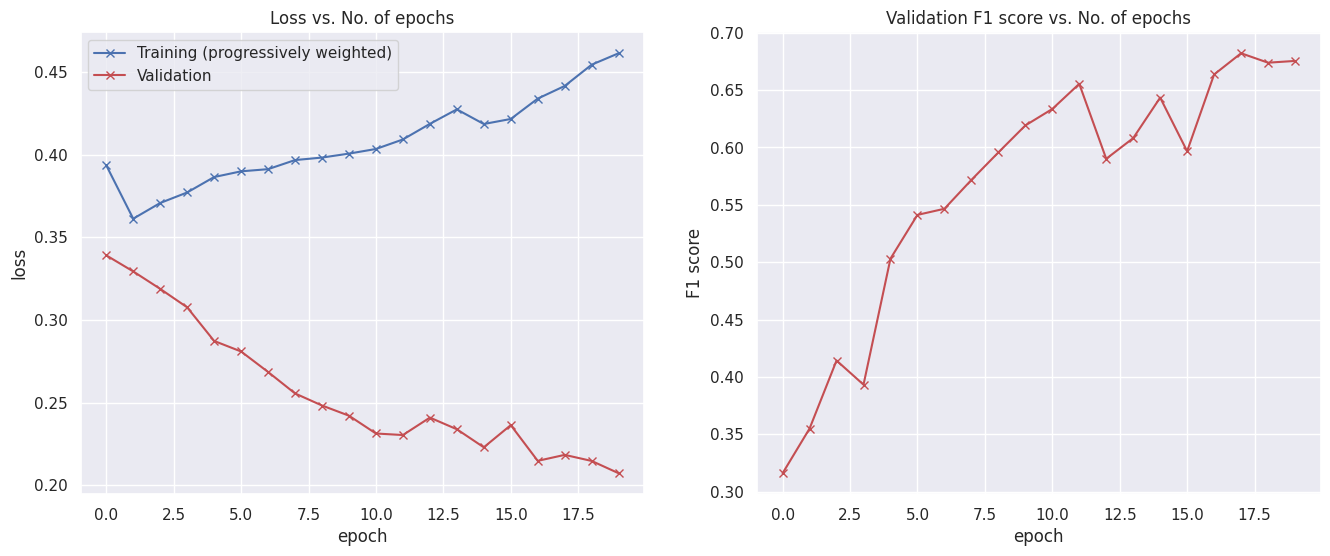

Training EfficientNetV2 on fold 10


100%|██████████| 433/433 [03:23<00:00,  2.13it/s]


Epoch [1], train_loss: 0.3937, val_loss: 0.3393, val_score: 0.3227


100%|██████████| 433/433 [03:29<00:00,  2.07it/s]


Epoch [2], train_loss: 0.3597, val_loss: 0.3297, val_score: 0.3639


100%|██████████| 433/433 [03:39<00:00,  1.97it/s]


Epoch [3], train_loss: 0.3697, val_loss: 0.3137, val_score: 0.4080


100%|██████████| 433/433 [03:43<00:00,  1.94it/s]


Epoch [4], train_loss: 0.3764, val_loss: 0.2996, val_score: 0.4428


100%|██████████| 433/433 [03:45<00:00,  1.92it/s]


Epoch [5], train_loss: 0.3841, val_loss: 0.2876, val_score: 0.4756


100%|██████████| 433/433 [03:43<00:00,  1.94it/s]


Epoch [6], train_loss: 0.3892, val_loss: 0.2815, val_score: 0.4910


100%|██████████| 433/433 [03:53<00:00,  1.85it/s]


Epoch [7], train_loss: 0.3893, val_loss: 0.2582, val_score: 0.5870


100%|██████████| 433/433 [03:55<00:00,  1.84it/s]


Epoch [8], train_loss: 0.3946, val_loss: 0.2492, val_score: 0.6371


100%|██████████| 433/433 [03:59<00:00,  1.81it/s]


Epoch [9], train_loss: 0.3981, val_loss: 0.2466, val_score: 0.6052


100%|██████████| 433/433 [04:00<00:00,  1.80it/s]


Epoch [10], train_loss: 0.3994, val_loss: 0.2510, val_score: 0.6156


100%|██████████| 433/433 [04:10<00:00,  1.73it/s]


Epoch [11], train_loss: 0.4039, val_loss: 0.2276, val_score: 0.6612


100%|██████████| 433/433 [04:11<00:00,  1.72it/s]


Epoch [12], train_loss: 0.4087, val_loss: 0.2288, val_score: 0.6621


100%|██████████| 433/433 [04:26<00:00,  1.62it/s]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-05.
Epoch [13], train_loss: 0.4196, val_loss: 0.2407, val_score: 0.6321


100%|██████████| 433/433 [04:27<00:00,  1.62it/s]


Epoch [14], train_loss: 0.4080, val_loss: 0.2152, val_score: 0.6867


100%|██████████| 433/433 [04:41<00:00,  1.54it/s]


Epoch [15], train_loss: 0.4201, val_loss: 0.2186, val_score: 0.6830


100%|██████████| 433/433 [04:42<00:00,  1.53it/s]


Epoch 00016: reducing learning rate of group 0 to 2.5000e-05.
Epoch [16], train_loss: 0.4259, val_loss: 0.2307, val_score: 0.6452


100%|██████████| 433/433 [04:53<00:00,  1.48it/s]


Epoch [17], train_loss: 0.4232, val_loss: 0.2143, val_score: 0.6834


100%|██████████| 433/433 [04:51<00:00,  1.49it/s]


Epoch [18], train_loss: 0.4307, val_loss: 0.2139, val_score: 0.6789


100%|██████████| 433/433 [04:45<00:00,  1.52it/s]


Epoch [19], train_loss: 0.4385, val_loss: 0.2038, val_score: 0.7133


100%|██████████| 433/433 [04:30<00:00,  1.60it/s]


Epoch [20], train_loss: 0.4484, val_loss: 0.1941, val_score: 0.7302


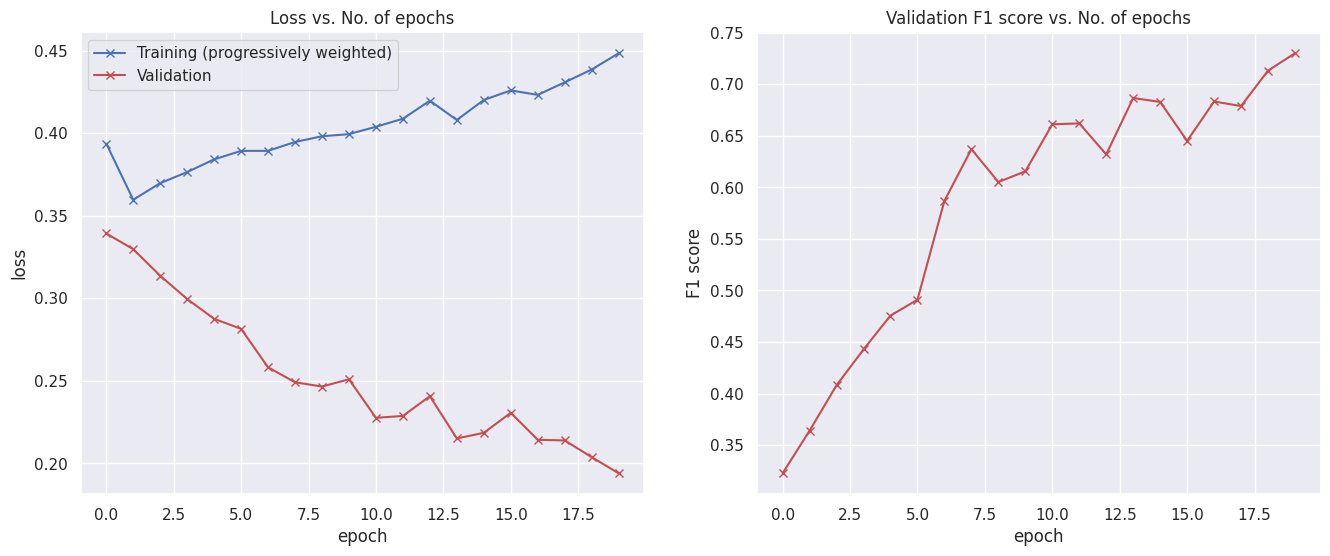

Time elapsed (minutes): 716.5017462412517


In [65]:
torch.cuda.empty_cache()
start = time.time()

# training and validation data
X = df['Image']
mlb = MultiLabelBinarizer()
y = pd.DataFrame(mlb.fit_transform(df['Label'].apply(lambda x: x.split(' '))), columns=mlb.classes_, index=df.index)

# test dataloader is the same for all folds
test_df = pd.read_csv(TEST_CSV)
test_ds = HumanProteinDataset(
    X = test_df['Image'].values.reshape(-1), y = np.array([[1] + [0] * 9] * len(test_df)),
    root_dir = TEST_DIR, transform = TRANSFORM_TEST)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

test_predictions = []
val_predictions = []
val_true = []

# stratified cross-validation split
strat = IterativeStratification(n_splits=N_SPLITS, order=1)
for fold, (train_idx, val_idx) in enumerate(strat.split(X.values.reshape(-1, 1), y.values)):
    # get fold split
    X_train, y_train = X.iloc[train_idx].values, y.iloc[train_idx].values
    X_val, y_val = X.iloc[val_idx].values, y.iloc[val_idx].values

    # create datasets
    train_ds = HumanProteinDataset(X_train, y_train, TRAIN_DIR, transform=TRANSFORM_TRAIN)
    valid_ds = HumanProteinDataset(X_val, y_val, TRAIN_DIR, transform=TRANSFORM_TEST)

    # create dataloaders
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

    # create and train model
    model = EfficientV2()
    print(f'Training EfficientNetV2 on fold {fold + 1}')
    history, model = fit(NUM_EPOCHS, LEARNING_RATE, model, train_dl, valid_dl)
    plot_history(history)
    # evaluate
    model.eval()
    model_val_predictions = [(nn.Sigmoid()(model(X.to(DEVICE)))).detach().cpu().numpy() for X, _ in valid_dl]
    test_model_predictions = [(nn.Sigmoid()(model(X.to(DEVICE)))).detach().cpu().numpy() for X, _ in test_dl]
    val_predictions.append(np.vstack(model_val_predictions).tolist())
    test_predictions.append(np.vstack(test_model_predictions).tolist())

    # save true labels for validation set
    val_true.append(y_val.tolist())

    # free memory
    del model, history
    torch.cuda.empty_cache()

# save lists of predictions
with open('./predictions/val_predictions.pkl', 'wb') as f:
    pickle.dump(val_predictions, f)
with open('./predictions/test_predictions.pkl', 'wb') as f:
    pickle.dump(test_predictions, f)
with open('./predictions/val_true.pkl', 'wb') as f:
    pickle.dump(val_true, f)

end = time.time()
print(f'Time elapsed (minutes): {(end - start) / 60}')

In [66]:
!zip -r /content/drive/MyDrive/FF/predictions.zip predictions/

  adding: predictions/ (stored 0%)
  adding: predictions/val_true.pkl (deflated 93%)
  adding: predictions/test_predictions.pkl (deflated 51%)
  adding: predictions/val_predictions.pkl (deflated 51%)


# Loading test and validation predictions, determining the optimal threshold, and creating the submission file

An appropriate threshold value was an important part of the final model performance. The threshold was determined by maximizing the F1-score on the validation set for each label separately.

In [67]:
# load predictions
with open('./predictions/test_predictions.pkl', 'rb') as f:
    test_predictions = pickle.load(f)
with open('./predictions/val_predictions.pkl', 'rb') as f:
    val_predictions = pickle.load(f)
with open('./predictions/val_true.pkl', 'rb') as f:
    val_true = pickle.load(f)

# average test predictions over folds
test_predictions_mean = np.mean(test_predictions, axis=0)

In [68]:
from torcheval.metrics.functional import binary_f1_score

def F1_validation(y_pred, y_true, threshold):
    """
    Computes the F1 score for each label and the average F1 score for 1 fold
    """
    f1s = [binary_f1_score(input = y_pred[:,i], target = y_true[:,i], threshold=threshold) for i in range(10)]
    f1s = torch.tensor(f1s)

    return f1s, torch.mean(f1s)

def compute_F1s(val_true_lists, val_pred_lists, threshold=THRESHOLD):
    """
    Computes the F1 scores for each fold and averages over all folds
    """
    F1s = []
    F1_avgs = []
    for i in range(len(val_true_lists)):
        val_true = torch.tensor(val_true_lists[i])
        val_pred = torch.tensor(val_pred_lists[i])
        F = F1_validation(val_pred, val_true, threshold=threshold)
        F1s.append(F[0])
        F1_avgs.append(F[1])

    F1s = torch.stack(F1s)
    F1_avgs = torch.stack(F1_avgs)
    return torch.mean(F1s, dim=0), torch.mean(F1_avgs, dim=0)

def test_thresholds(val_true_lists, val_pred_lists):
    """
    Computes the F1 at different thresholds and plots the results
    """
    thresholds = np.arange(0., 1., 0.01)
    df = pd.DataFrame(columns=["Average F1"] + [(label_map[i] + " (" + str(i) + ")") for i in range(10)], index=np.arange(0., 1., 0.01))
    for threshold in thresholds:
        F = compute_F1s(val_true_lists, val_pred_lists, threshold=threshold)
        df.loc[threshold] = [F[1].item()] + F[0].tolist()

    return df.astype(float)

df = test_thresholds(val_true, val_predictions)

Optimal thresholds:
Average F1                       0.33
Mitochondria (0)                 0.33
Nuclear bodies (1)               0.32
Nucleoli (2)                     0.33
Golgi apparatus (3)              0.30
Nucleoplasm (4)                  0.39
Nucleoli fibrillar center (5)    0.41
Cytosol (6)                      0.34
Plasma membrane (7)              0.35
Centrosome (8)                   0.26
Nuclear speckles (9)             0.39
dtype: float64

Optimal F1 scores:
Average F1                       0.680882
Mitochondria (0)                 0.746581
Nuclear bodies (1)               0.618259
Nucleoli (2)                     0.709518
Golgi apparatus (3)              0.716033
Nucleoplasm (4)                  0.840829
Nucleoli fibrillar center (5)    0.614883
Cytosol (6)                      0.712798
Plasma membrane (7)              0.663688
Centrosome (8)                   0.532555
Nuclear speckles (9)             0.694741
dtype: float64


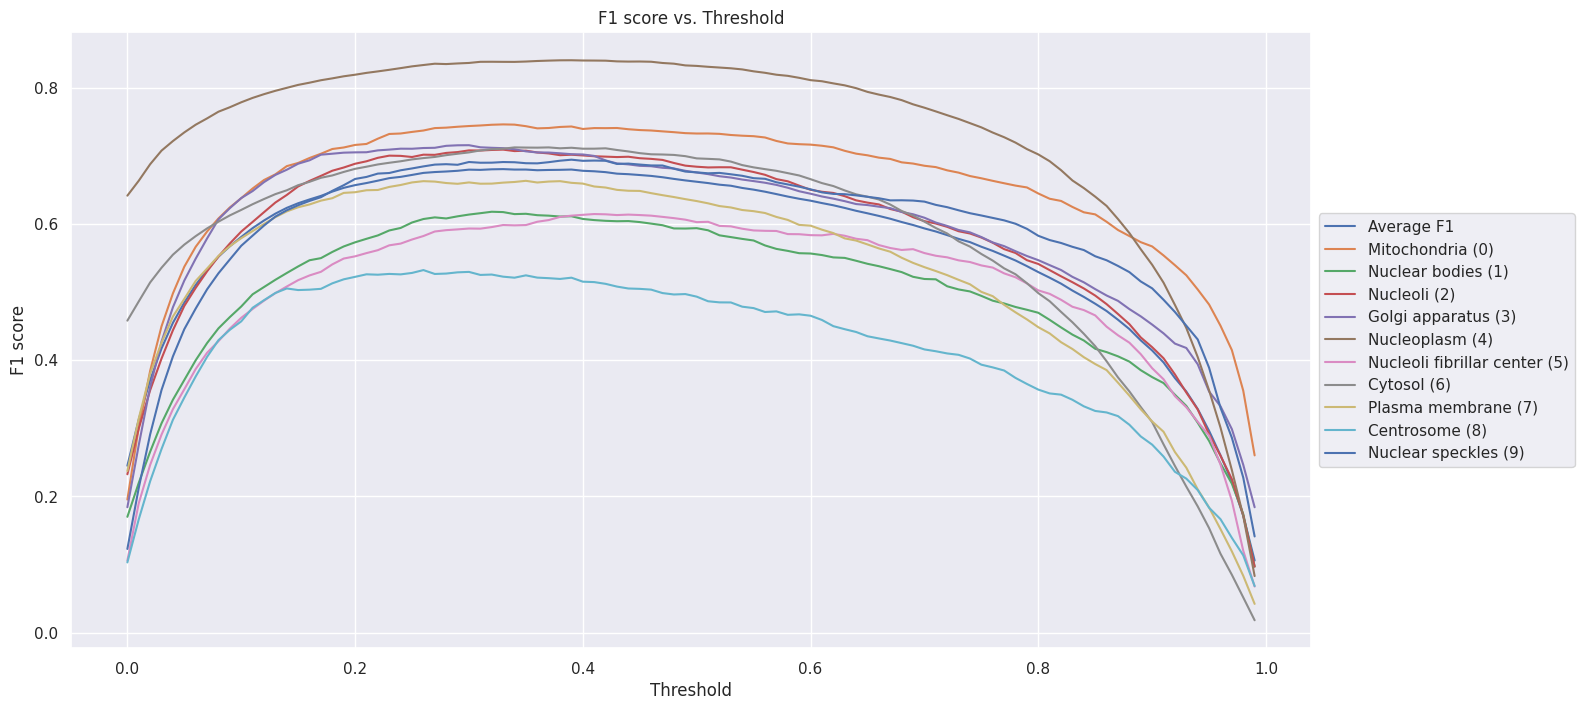

In [69]:
fig = df.plot(figsize=(16, 8), title="F1 score vs. Threshold", xlabel="Threshold", ylabel="F1 score", grid=True)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

optimal_thresholds = df.idxmax()
optimal_F1s = df.max()

print("Optimal thresholds:")
print(optimal_thresholds)
print("\nOptimal F1 scores:")
print(optimal_F1s)

In [70]:
def decode_test_predictions(test_predictions, optimal_thresholds):
    """
    Decodes the test predictions into labels
    """
    test_predictions_decoded = []
    for i in range(len(test_predictions)):
        pred = test_predictions[i]
        out  = []
        for j in range(10):
            if pred[j] >= optimal_thresholds[j + 1]:
                out.append(str(j))
        test_predictions_decoded.append(' '.join(out))

    return test_predictions_decoded

result = decode_test_predictions(test_predictions_mean, optimal_thresholds)
# create submission file
submission_df = pd.read_csv(TEST_CSV)
submission_df["Label"] = result
submission_df.to_csv('./predictions/submission.csv', index=False)

submission_df

,Image,Label
0,25880,3
1,7810,3 6
2,23748,4 7
3,24621,6 7
4,30169,7
...,...,...
3842,7826,4
3843,23761,4 6
3844,17766,2 4 6
3845,25378,4 6


# Uncertainty estimation

Model prediction-probabilities and over/under-confidence will be assessed using the `pycalib` package. We note that under-represented classes give rist to the least calibrated predictions.

Since no test-set ground truth labels were provided, the validation data of the different folds is used for assessing model calibration.

0.18763620942850046
0.022529845734821634


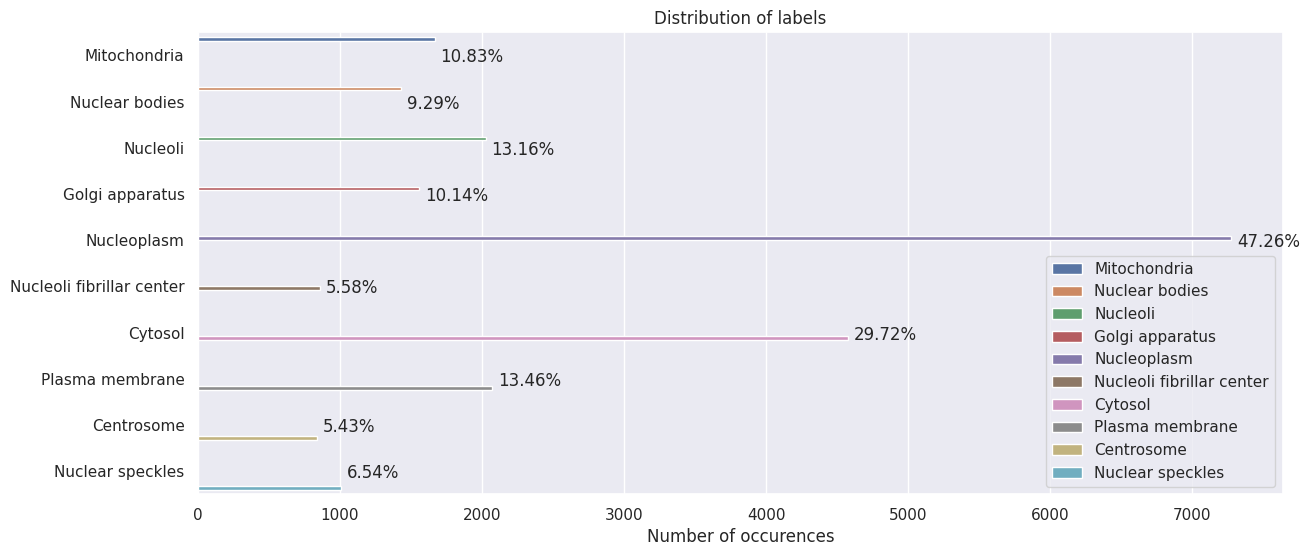

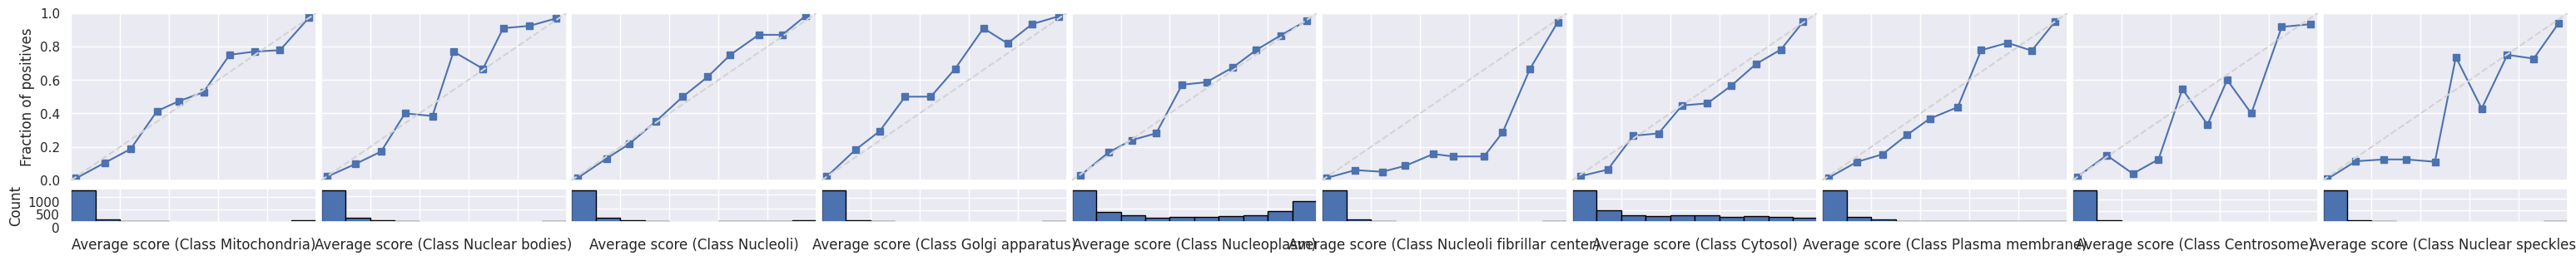

In [71]:
myFold = 0
y_true = np.asarray(val_true[myFold])
probs = np.asarray(val_predictions[myFold])

print(conf_ECE(y_true, probs))
print(classwise_ECE(y_true, probs))
prd = plot_reliability_diagram(
    y_true, probs, show_histogram=True,
    class_names=[label for label in label_map.values()])

class_imbalance_plot

In [72]:
conf_ECEs = [conf_ECE(np.asarray(val_true[i]), np.asarray(val_predictions[i])) for i in range(len(val_true))]
print("Average confidence ECE :", np.mean(conf_ECEs))
classwise_ECEs = [classwise_ECE(np.asarray(val_true[i]), np.asarray(val_predictions[i])) for i in range(len(val_true))]
print("Average classwise ECE  :", np.mean(classwise_ECEs))

Average confidence ECE : 0.20472873710192094
Average classwise ECE  : 0.022864325262751152


<ipython-input-73-d388b9445dcf>:19: RuntimeWarning: Mean of empty slice
  bin_score = [np.nanmean(probs[bin_index == i, label]) for i in range(1, n_bins + 1)]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


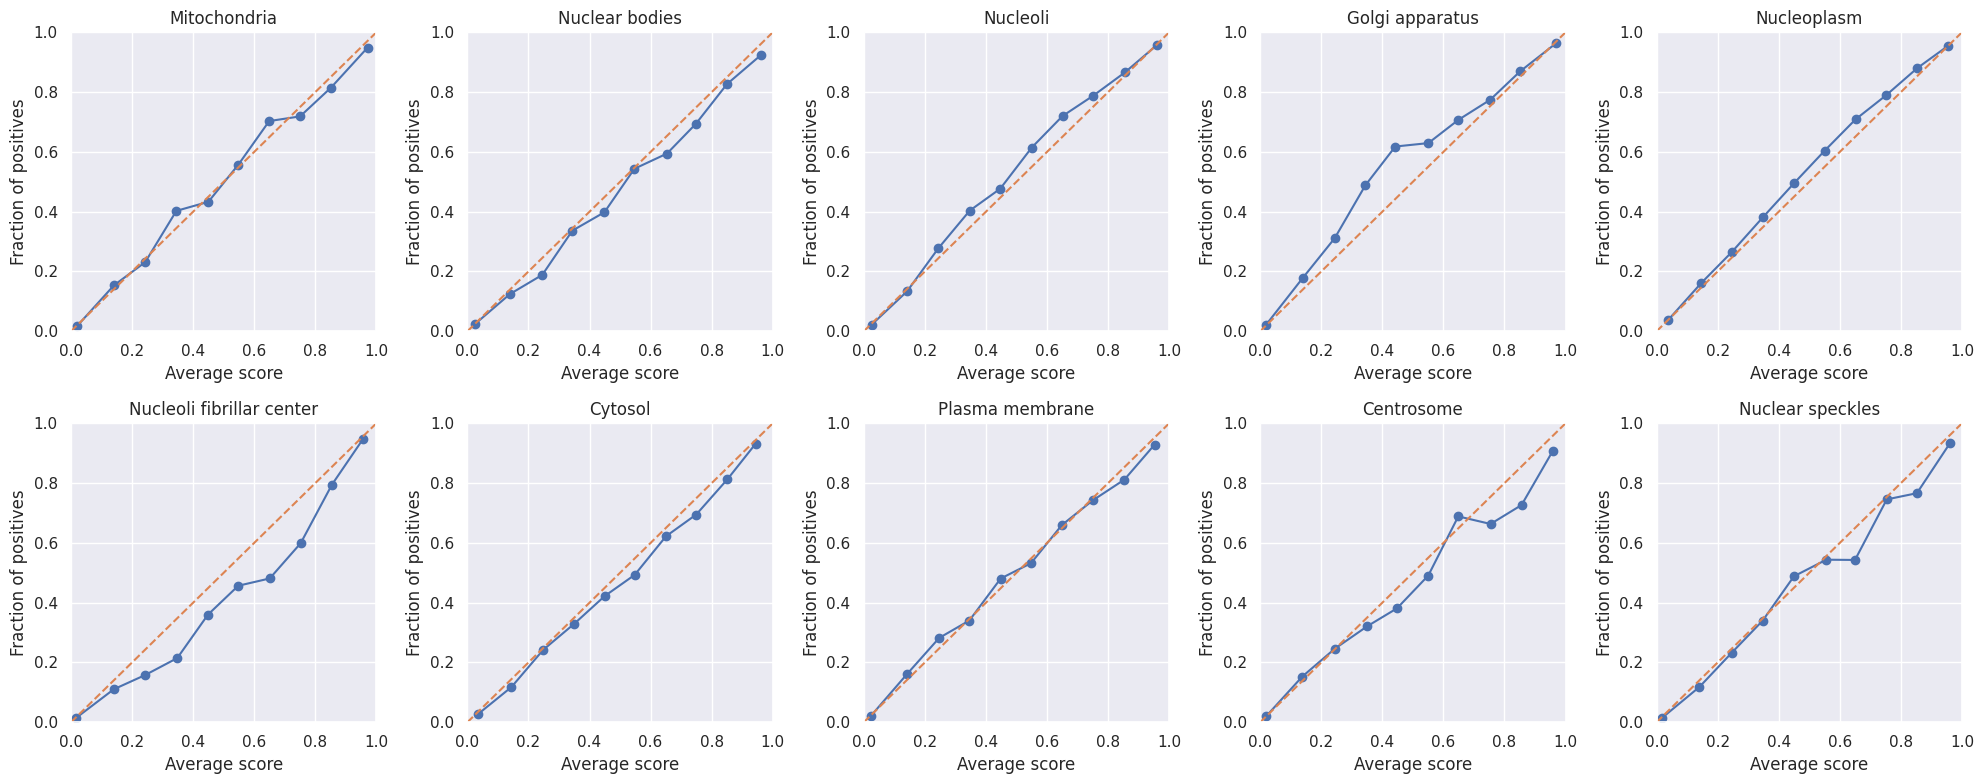

In [73]:
# plot reliability diagram of all folds averaged

n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)
total_bin_scores = []
total_bin_trues = []

for myFold in range(N_SPLITS):
    y_true = np.asarray(val_true[myFold])
    probs = np.asarray(val_predictions[myFold])
    # this fold's reliability metrics for each label
    bin_scores = []
    bin_trues = []

    for label in range(NUM_CLASSES):
        # assign each prediction to a bin
        bin_index = np.digitize(probs[:, label], bins)
        # compute mean score for each bin
        bin_score = [np.nanmean(probs[bin_index == i, label]) for i in range(1, n_bins + 1)]
        # compute mean fraction of positives for each bin
        bin_true = [np.nanmean(y_true[bin_index == i, label]) for i in range(1, n_bins + 1)]

        bin_scores.append(bin_score)
        bin_trues.append(bin_true)

    total_bin_scores.append(bin_scores) # shape: fold × class × bin
    total_bin_trues.append(bin_trues)

# average over folds
avg_bin_scores = np.nanmean(total_bin_scores, axis=0)
avg_bin_trues = np.nanmean(total_bin_trues, axis=0)

# plot
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(NUM_CLASSES):
    ax[i // 5, i % 5].plot(avg_bin_scores[i], avg_bin_trues[i], '-o')
    ax[i // 5, i % 5].plot([0, 1], [0, 1], '--')
    ax[i // 5, i % 5].set_title(label_map[i])
    ax[i // 5, i % 5].set_ylabel('Fraction of positives')
    ax[i // 5, i % 5].set_xlabel('Average score')
    ax[i // 5, i % 5].set_xlim([0, 1])
    ax[i // 5, i % 5].set_ylim([0, 1])
plt.tight_layout()
plt.show()

We note that averaging out the predictions of the different folds gives a more calibrated model.

In [74]:
!zip /content/drive/MyDrive/FF/submission.zip predictions/submission.csv

  adding: predictions/submission.csv (deflated 57%)
